# Correlation Validation (Data From ChatGPT)
Validating the effectiveness of a correlation model is crucial to ensure that the model accurately captures the relationship between tested variables and avoids misleading conclusions. A poorly validated correlation models can lead to false assumptions, the misinterpretation of results, ineffective decision-making, incorrect predictions, and the wasted expenditure of time, energy, labor, and resources.

Choosing a model depends on the kind of data we aim to validate and its spread across the dataset. The following notebook contains the processing of our test data to ensure that the model we chose is the most fitting for our analysis.

## Grabbing our Tools



CVE-2017-6751 has a CVSS v3.0 base score of 9.8, which is categorized as `Critical`.

- Key details:
- Attack Vector: Network
- Attack Complexity: Low
- Privileges Required: None
- User Interaction: None
- Scope: Unchanged
- Confidentiality Impact: High
- Integrity Impact: High
- Availability Impact: High

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

## Getting our Test Data

In [2]:
df = pd.read_excel('../data/correlation-validation-data.xlsx')
df.head()

,Attack,Unnamed: 1,CVE,CVE List Date,Exploit date,Patch Release Date,Patch/device manufacturer,Affected Devices,CVSS,CVSS status
0,VPN Filter malware,Iot,CVE-2017-6742,2017-10-17,2018-05-24,2018-06-27 00:00:00,CISCO,CISCO routers,9.8,Critical
1,VPN Filter malware,IoT,CVE-2017-6750,2017-10-17,2018-05-24,2018-06-27 00:00:00,CISCO,"CISCO routers, network devices",9.8,Critical
2,VPN Filter malware,IoT,CVE-2017-6751,2017-10-17,2018-05-24,2018-06-27 00:00:00,CISCO,CISCO routers,9.8,Critical
3,VPN Filter malware,NaN,CVE-2017-12074,2017-08-24,2018-05-24,2018-06-27 00:00:00,CISCO,consumer routers,8.8,High
4,VPN Filter malware,NaN,CVE-2017-12075,2017-08-24,2018-05-24,2018-06-27 00:00:00,CISCO,"CISCO routers, network devices",8.8,High


In [3]:
df.columns.to_list()

['Attack ',
 'Unnamed: 1',
 'CVE ',
 'CVE List Date',
 'Exploit date',
 'Patch Release Date',
 'Patch/device manufacturer',
 'Affected Devices',
 'CVSS ',
 'CVSS status']

## Rename Columns

In [4]:
rename = {
    'Attack ': 'Attack_Name',
    'Unnamed: 1': 'IoT',
    'CVE ': 'CVE_ID',
    'CVE List Date': 'CVE_List_Date',
    'Exploit date': 'Date_Of_First_Exploit',
    'Patch Release Date': 'Patch_Release_Date',
    'Patch/device manufacturer': 'Patch/Device_Manufacturer',
    'Affected Devices': 'Affected_Devices',
    'CVSS ': 'CVSS',
    'CVSS status': 'CVSS_Status'
}

df = df.rename(rename, axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Attack_Name                37 non-null     object        
 1   IoT                        3 non-null      object        
 2   CVE_ID                     37 non-null     object        
 3   CVE_List_Date              37 non-null     datetime64[ns]
 4   Date_Of_First_Exploit      37 non-null     datetime64[ns]
 5   Patch_Release_Date         37 non-null     object        
 6   Patch/Device_Manufacturer  7 non-null      object        
 7   Affected_Devices           13 non-null     object        
 8   CVSS                       37 non-null     float64       
 9   CVSS_Status                37 non-null     object        
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 3.0+ KB


In [5]:
df.head(3)

,Attack_Name,IoT,CVE_ID,CVE_List_Date,Date_Of_First_Exploit,Patch_Release_Date,Patch/Device_Manufacturer,Affected_Devices,CVSS,CVSS_Status
0,VPN Filter malware,Iot,CVE-2017-6742,2017-10-17,2018-05-24,2018-06-27 00:00:00,CISCO,CISCO routers,9.8,Critical
1,VPN Filter malware,IoT,CVE-2017-6750,2017-10-17,2018-05-24,2018-06-27 00:00:00,CISCO,"CISCO routers, network devices",9.8,Critical
2,VPN Filter malware,IoT,CVE-2017-6751,2017-10-17,2018-05-24,2018-06-27 00:00:00,CISCO,CISCO routers,9.8,Critical


Fix typos in `IoT` column.

In [5]:
df['IoT'] = df['IoT'].replace(['IoT', 'Iot'], True)

In order to process the date variables, the `?` characters need to be converted into null values that Pandas doesn't confuse with non-null text data.

In [6]:
df['Patch_Release_Date'] = df['Patch_Release_Date'].replace('?', pd.NA)

Because not every representation of a null value is handled by Python in the same way, I'm going to standardize them.

In [7]:
null_values = ['NaN', np.nan, '', ' ', None]

df = df.replace(null_values, pd.NA)

## Filter Out Empty Values
Doing the validation won't be possible with empty values in the variables we want to correlate, so I'll filter out the nulls for our columns of interest (`CVE_List_Date`, `Date_Of_First_Exploit`, `Patch_Release_Date`, `CVSS`, and `CVSS_Status`).

In [23]:
df = df[df[[
    'CVE_List_Date',
    'Date_Of_First_Exploit',
    'Patch_Release_Date',
    'CVSS', 'CVSS_Status'
]].notna().all(axis=1)]

We'll convert the patch release dates to a proper datetime format and standardize the categorical data inside `CVSS_Status`.

In [9]:
df['Patch_Release_Date'] = pd.to_datetime(df['Patch_Release_Date'], errors='raise')

In [10]:
# Lowercase statuses
df['CVSS_Status'] = [x.lower() for x in df['CVSS_Status']]

# Fix typo
df['CVSS_Status'] = df['CVSS_Status'].replace('meium', 'medium')


## Validation of CVSS to CVSS Status
Next, we'll validate that the `CVSS_Status` is correctly mapped to the appropriate score.

In [13]:
def map_cvss_to_category(score):
    if score >= 9.0:
        return 'critical'
    elif score >= 7.0:
        return 'high'
    elif score >= 4.0:
        return 'medium'
    elif score > 0.0:
        return 'low'
    elif score == 0.0:
        return 'none'
    return None

# Remove white space so that validation doesn't fail for mysterious reasons
df['CVSS_Status'] = df['CVSS_Status'].str.strip()

# Validate the mapping
df['Validation'] = df.apply(
    lambda row: row['CVSS_Status'] == map_cvss_to_category(
        row['CVSS']
    ), axis=1
)

# Identify mismatches
mismatches = (df['Validation'] == False).sum()
print(f'There was {mismatches} incorrectly-mapped CVSS status.' if mismatches == 1 else f'There were {mismatches} incorrectly-mapped CVSS statuses.')

# Recalibrate CVSS status based on CVSS score
df['CVSS_Status'] = df['CVSS'].apply(map_cvss_to_category)

There were 0 incorrectly-mapped CVSS statuses.


In [14]:

# Convert CVSS status to ordered categorical data
order = ['none', 'low', 'medium', 'high', 'critical']
df['CVSS_Status'] = pd.Categorical(df['CVSS_Status'], categories=order, ordered=True)

In [16]:
# Drop presently unnecessary columns
df = df.drop(columns=['Validation'])

In [27]:
df.head(3)

,Attack_Name,IoT,CVE_ID,CVE_List_Date,Date_Of_First_Exploit,Patch_Release_Date,Patch/Device_Manufacturer,Affected_Devices,CVSS,CVSS_Status
0,VPN Filter malware,True,CVE-2017-6742,2017-10-17,2018-05-24,2018-06-27,CISCO,CISCO routers,9.8,critical
1,VPN Filter malware,True,CVE-2017-6750,2017-10-17,2018-05-24,2018-06-27,CISCO,"CISCO routers, network devices",9.8,critical
2,VPN Filter malware,True,CVE-2017-6751,2017-10-17,2018-05-24,2018-06-27,CISCO,CISCO routers,9.8,critical


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 0 to 36
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Attack_Name                35 non-null     object        
 1   IoT                        3 non-null      object        
 2   CVE_ID                     35 non-null     object        
 3   CVE_List_Date              35 non-null     datetime64[ns]
 4   Date_Of_First_Exploit      35 non-null     datetime64[ns]
 5   Patch_Release_Date         35 non-null     datetime64[ns]
 6   Patch/Device_Manufacturer  7 non-null      object        
 7   Affected_Devices           11 non-null     object        
 8   CVSS                       35 non-null     float64       
 9   CVSS_Status                35 non-null     category      
dtypes: category(1), datetime64[ns](3), float64(1), object(5)
memory usage: 3.0+ KB


## Time to Patch and Time to Exploit
Calculate the number of days between when the CVE was listed, when it was first exploited, and when a patch for it was released.

In [28]:
df['Time_To_Patch'] = (df['Patch_Release_Date'] - df['CVE_List_Date']).dt.days
df['Time_To_Exploit'] = (df['Date_Of_First_Exploit'] - df['CVE_List_Date']).dt.days

In [29]:
df.describe()

,CVE_List_Date,Date_Of_First_Exploit,Patch_Release_Date,CVSS,Time_To_Patch,Time_To_Exploit
count,35,35,35,35.000000,35.000000,35.000000
mean,2017-11-10 17:49:42.857142784,2018-08-06 07:32:34.285714176,2018-01-30 11:39:25.714285824,7.697143,80.742857,268.571429
min,2014-01-31 00:00:00,2014-10-01 00:00:00,2014-07-01 00:00:00,5.000000,0.000000,-11.000000
25%,2015-03-07 00:00:00,2015-12-23 00:00:00,2015-04-15 00:00:00,7.450000,0.000000,61.000000
50%,2017-10-13 00:00:00,2017-12-13 00:00:00,2017-10-13 00:00:00,7.500000,27.000000,273.000000
75%,2020-08-11 00:00:00,2020-08-19 00:00:00,2020-08-11 00:00:00,8.700000,149.000000,438.500000
max,2022-05-10 00:00:00,2023-04-25 00:00:00,2022-06-06 00:00:00,9.800000,358.000000,691.000000
std,NaN,NaN,NaN,1.371450,111.962269,207.274510


## Verifying Distributive Normalcy
From the looks of the histogram plots, the CVSS scores seem normal but the days to patch and days to exploit don't seem normal. To verify this, we can use the Shapiro-Wilks test to statistically test for normalcy. If the `p` value is less than `0.05`, the data is likely not normally distributed.

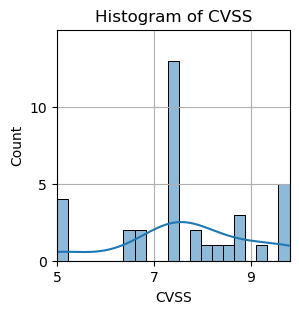

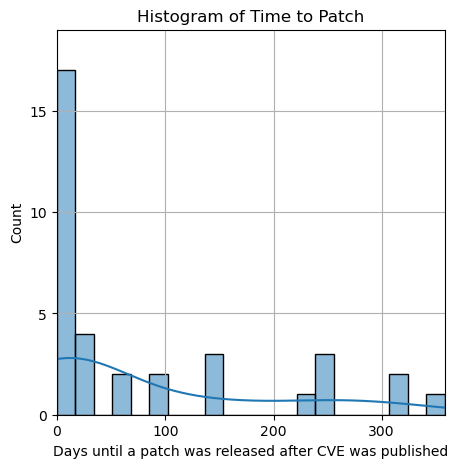

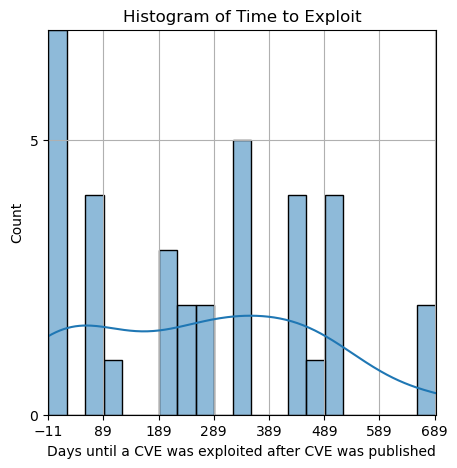

In [56]:
# Visualize normality visually for CVSS
plt.figure(figsize=(3, 3))
sns.histplot(df['CVSS'], kde=True, bins=21)
plt.title('Histogram of CVSS')
min_x = df['CVSS'].min()
max_x = df['CVSS'].max()
plt.xlim(min_x, max_x)
plt.xticks(np.arange(min_x, max_x, 2))
max_y = df['CVSS'].value_counts().max() + 3
plt.ylim(0, max_y)
plt.yticks(np.arange(0, max_y, 5))
plt.grid(True)
plt.show()

# Visualize normality visually for CVSS
plt.figure(figsize=(5, 5))
sns.histplot(df['Time_To_Patch'], kde=True, bins=21)
plt.title('Histogram of Time to Patch')
plt.xlabel('Days until a patch was released after CVE was published')
min_x = df['Time_To_Patch'].min()
max_x = df['Time_To_Patch'].max()
plt.xlim(min_x, max_x)
plt.xticks(np.arange(min_x, max_x, 100))
max_y = df['Time_To_Patch'].value_counts().max() + 3
plt.ylim(0, max_y)
plt.yticks(np.arange(0, max_y, 5))
plt.grid(True)
plt.show()

# Visualize normality visually for CVSS
plt.figure(figsize=(5, 5))
sns.histplot(df['Time_To_Exploit'], kde=True, bins=21)
plt.title('Histogram of Time to Exploit')
plt.xlabel('Days until a CVE was exploited after CVE was published')
min_x = df['Time_To_Exploit'].min()
max_x = df['Time_To_Exploit'].max()
plt.xlim(min_x, max_x)
plt.xticks(np.arange(min_x, max_x, 100))
max_y = df['Time_To_Exploit'].value_counts().max() + 3
plt.ylim(0, max_y)
plt.yticks(np.arange(0, max_y, 5))
plt.grid(True)
plt.show()

In [55]:
# Statistical test for normalcy using Shapiro-Wilk tests
CVSS_stat, CVSS_p_value = stats.shapiro(df['CVSS'])
CVSS_stat = round(CVSS_stat, 5)
CVSS_p_value = round(CVSS_p_value, 5)

TTP_stat, TTP_p_value = stats.shapiro(df['Time_To_Patch'])
TTP_stat = round(TTP_stat, 5)
TTP_p_value = round(TTP_p_value, 5)

TTE_stat, TTE_p_value = stats.shapiro(df['Time_To_Exploit'])
TTE_stat = round(TTE_stat, 5)
TTE_p_value = round(TTE_p_value, 5)

print(f'Shapiro-Wilk Test for CVSS: stat={CVSS_stat}, p-value={CVSS_p_value}')
print(f'Shapiro-Wilk Test for Time to Patch: stat={TTP_stat}, p-value={TTP_p_value}')
print(f'Shapiro-Wilk Test for Time to Exploit: stat={TTE_stat}, p-value={TTE_p_value}')

Shapiro-Wilk Test for CVSS: stat=0.90756, p-value=0.00635
Shapiro-Wilk Test for Time to Patch: stat=0.74387, p-value=0.0
Shapiro-Wilk Test for Time to Exploit: stat=0.92603, p-value=0.02136


Considering the `p` values for all of our variables are less than or significantly less than `0.05`, then it follows we must reject the null hypothesis that the data are normally distributed. This means we cannot rely on Pearson's correlation coefficient. We are left with Spearman's rank correlation and Kendall's Tau. Which of these correlation methods to use depends on the number of duplicates that occur in the data as well as the sample size.

In [63]:
num_total_values = len(df['CVSS'])

# Determine number of ties in data
num_unique_CVSS_values = df['CVSS'].nunique()
num_unique_TTP_values = df['Time_To_Patch'].nunique()
num_unique_TTE_values = df['Time_To_Exploit'].nunique()

print(f'Total number of values: {num_total_values}')
print(f'Number of unique CVSS values: {num_unique_CVSS_values}')
print(f'Number of unique Time to Patch values: {num_unique_TTP_values}')
print(f'Number of unique Time to Exploit values: {num_unique_TTE_values}')


if num_unique_CVSS_values < num_total_values:
    print(f'There are {num_total_values - num_unique_CVSS_values} tied values in "CVSS"')
if num_unique_TTP_values < num_total_values:
    print(f'There are {num_total_values - num_unique_TTP_values} tied values in "Time_To_Patch"')
if num_unique_TTE_values < num_total_values:
    print(f'There are {num_total_values - num_unique_TTE_values} tied values in "Time_To_Exploit"')

Total number of values: 35
Number of unique CVSS values: 12
Number of unique Time to Patch values: 12
Number of unique Time to Exploit values: 19
There are 23 tied values in "CVSS"
There are 23 tied values in "Time_To_Patch"
There are 16 tied values in "Time_To_Exploit"


Because of the prevalence of duplicate values in our columns of interest, we'll most likely want to use Kendall's Tau to calculate the correlation between our variables, but I'm going to run tests using Spearman's rank correlation as well to inform a more definitive choice. We also have to think about the sample size of the test versus our final data. Spearman's correlation could be better suited for larger datasets, especially if our larger dataset has less duplicated data. If we really wanted to, we could resample our test data with bootstrapping and then calculate the standard deviation of the correlation coefficients produced by both methods to guage which is more reliable.

In [62]:
cvss = df['CVSS']
ttp = df['Time_To_Patch']
tte = df['Time_To_Exploit']

# Spearman's Correlation: Test the relationship between CVSS scores and the time to patch
spearman_corr, spearman_p = stats.spearmanr(cvss, ttp)

# Kendall's Tau: Test the relationship between CVSS scores and the time to patch
kendall_corr, kendall_p = stats.kendalltau(cvss, ttp)

print(f"Spearman's correlation between CVSS and TTP: {spearman_corr}, p-value: {spearman_p}")
print(f"Kendall's Tau correlation between CVSS and TTP: {kendall_corr}, p-value: {kendall_p}")

# Spearman's Correlation: Test the relationship between CVSS scores and the time to exploit
spearman_corr, spearman_p = stats.spearmanr(cvss, tte)

# Kendall's Tau: Test the relationship between CVSS scores and the time to exploit
kendall_corr, kendall_p = stats.kendalltau(cvss, tte)

print(f"Spearman's correlation between CVSS and TTE: {spearman_corr}, p-value: {spearman_p}")
print(f"Kendall's Tau correlation between CVSS and TTE: {kendall_corr}, p-value: {kendall_p}")

Spearman's correlation between CVSS and TTP: 0.2524912266716553, p-value: 0.14337461719197098
Kendall's Tau correlation between CVSS and TTP: 0.14828664533584598, p-value: 0.26893767039768757
Spearman's correlation between CVSS and TTE: -0.49465357986295666, p-value: 0.0025222320526764284
Kendall's Tau correlation between CVSS and TTE: -0.38405113665520846, p-value: 0.0025070699313095267


Both correlation models show a slight positive relationship between `CVSS` and `Time_To_Patch`, but the `p` value indicates that we cannot reject the null hypothesis. We can't be sure that as the criticality of `CVSS` increases, so to does the time it takes for a patch to be delivered. On the other hand, both correlation models do demonstrate a statistically significant negative relationship between `CVSS` and `Time_To_Exploit`, suggesting that as the criticality goes up, the amount of time it takes for a CVE to be exploited goes down. The next task will be to do a bootstrap resample to calculate the standard deviation of the coefficients across time in an effort to measure each method's reliability.

In [66]:
# Number of bootstrap iterations to perform
iterations = 1000

# Storage units for both correlation models' coefficients across iterations
spearman_corrs_cvss_ttp = []
kendall_corrs_cvss_ttp = []
spearman_corrs_cvss_tte = []
kendall_corrs_cvss_tte = []

# Storage units for the number of times our correlations were statistically significant across resamplings
spearman_ss_cvss_ttp = 0
kendall_ss_cvss_ttp = 0
spearman_ss_cvss_tte = 0
kendall_ss_cvss_tte = 0

# If we didn't already know (which we do), we'd drop any empty values here and make sure that each variable of interest contain the same number of observations

# Perform bootstrapping
for _ in range(iterations):
    sample_index = np.random.choice(len(cvss), size=len(cvss), replace=True) # Grab as many observations as are in the original sample and create a new sampling with the same amount of observations

    # Grab the values in each column for the specified index
    cvss_sample = cvss.iloc[sample_index]
    ttp_sample = ttp.iloc[sample_index]
    tte_sample = tte.iloc[sample_index]

    # Calculate Spearman and Kendall correlations and p-values
    spearman_corr_cvss_ttp, spearman_p_cvss_ttp = stats.spearmanr(cvss_sample, ttp_sample)
    kendall_corr_cvss_ttp, kendall_p_cvss_ttp = stats.kendalltau(cvss_sample, ttp_sample)
    spearman_corr_cvss_tte, spearman_p_cvss_tte = stats.spearmanr(cvss_sample, tte_sample)
    kendall_corr_cvss_tte, kendall_p_cvss_tte = stats.kendalltau(cvss_sample, tte_sample)

    # Append correlation coefficients to storage units
    spearman_corrs_cvss_ttp.append(spearman_corr_cvss_ttp)
    kendall_corrs_cvss_ttp.append(kendall_corr_cvss_ttp)
    spearman_corrs_cvss_tte.append(spearman_corr_cvss_tte)
    kendall_corrs_cvss_tte.append(kendall_corr_cvss_tte)

    # Count the frequency of p values that show statistical significance
    if spearman_p_cvss_ttp < 0.05:
        spearman_ss_cvss_ttp += 1
    if kendall_p_cvss_ttp < 0.05:
        kendall_ss_cvss_ttp += 1
    if spearman_p_cvss_tte < 0.05:
        spearman_ss_cvss_tte += 1
    if kendall_p_cvss_tte < 0.05:
        kendall_ss_cvss_tte += 1

# Calculate mean and standard deviation of correlation coefficients
mean_spearman_corrs_cvss_ttp = np.mean(spearman_corrs_cvss_ttp)
mean_kendall_corrs_cvss_ttp = np.mean(kendall_corrs_cvss_ttp)
mean_spearman_corrs_cvss_tte = np.mean(spearman_corrs_cvss_tte)
mean_kendall_corrs_cvss_tte = np.mean(kendall_corrs_cvss_tte)

std_spearman_corrs_cvss_ttp = np.std(spearman_corrs_cvss_ttp)
std_kendall_corrs_cvss_ttp = np.std(kendall_corrs_cvss_ttp)
std_spearman_corrs_cvss_tte = np.std(spearman_corrs_cvss_tte)
std_kendall_corrs_cvss_tte = np.std(kendall_corrs_cvss_tte)

print(f"Spearman's correlation between CVSS and Time to Patch\nMEAN: {mean_spearman_corrs_cvss_ttp}\nSTANDARD DEVIATION: {std_spearman_corrs_cvss_ttp}\n% OF SIGNIFICANT SAMPLES: {round(spearman_ss_cvss_ttp / iterations, 2) * 100}%\n")
print(f"Kendall's correlation between CVSS and Time to Patch\nMEAN: {mean_kendall_corrs_cvss_ttp}\nSTANDARD DEVIATION: {std_kendall_corrs_cvss_ttp}\n% OF SIGNIFICANT SAMPLES: {round(kendall_ss_cvss_ttp / iterations, 2) * 100}%\n")
print(f"Spearman's correlation between CVSS and Time to Exploit\nMEAN: {mean_spearman_corrs_cvss_tte}\nSTANDARD DEVIATION: {std_spearman_corrs_cvss_tte}\n% OF SIGNIFICANT SAMPLES: {round(spearman_ss_cvss_tte / iterations, 2) * 100}%\n")
print(f"Kendall's correlation between CVSS and Time to Exploit\nMEAN: {mean_kendall_corrs_cvss_tte}\nSTANDARD DEVIATION: {std_kendall_corrs_cvss_tte}\n% OF SIGNIFICANT SAMPLES: {round(kendall_ss_cvss_tte / iterations, 2) * 100}%\n")

Spearman's correlation between CVSS and Time to Patch
MEAN: 0.25091637736987554
STANDARD DEVIATION: 0.19258945173850223
% OF SIGNIFICANT SAMPLES: 35.0%

Kendall's correlation between CVSS and Time to Patch
MEAN: 0.15308062138106474
STANDARD DEVIATION: 0.1527699853233688
% OF SIGNIFICANT SAMPLES: 25.0%

Spearman's correlation between CVSS and Time to Exploit
MEAN: -0.48061755302345593
STANDARD DEVIATION: 0.14280969954983905
% OF SIGNIFICANT SAMPLES: 84.0%

Kendall's correlation between CVSS and Time to Exploit
MEAN: -0.3797875502424944
STANDARD DEVIATION: 0.11458229272201138
% OF SIGNIFICANT SAMPLES: 85.0%



The lower standard deviation of Kendall's Tau suggests that this correlation method is more reliably gauging the correlation between our variables of interest.

In [59]:
df.head(35)

,Attack_Name,IoT,CVE_ID,CVE_List_Date,Date_Of_First_Exploit,Patch_Release_Date,Patch/Device_Manufacturer,Affected_Devices,CVSS,CVSS_Status,Time_To_Patch,Time_To_Exploit
0,VPN Filter malware,True,CVE-2017-6742,2017-10-17,2018-05-24,2018-06-27,CISCO,CISCO routers,9.8,critical,253,219
1,VPN Filter malware,True,CVE-2017-6750,2017-10-17,2018-05-24,2018-06-27,CISCO,"CISCO routers, network devices",9.8,critical,253,219
2,VPN Filter malware,True,CVE-2017-6751,2017-10-17,2018-05-24,2018-06-27,CISCO,CISCO routers,9.8,critical,253,219
3,VPN Filter malware,<NA>,CVE-2017-12074,2017-08-24,2018-05-24,2018-06-27,CISCO,consumer routers,8.8,high,307,273
4,VPN Filter malware,<NA>,CVE-2017-12075,2017-08-24,2018-05-24,2018-06-27,CISCO,"CISCO routers, network devices",8.8,high,307,273
5,VPN Filter malware,<NA>,CVE-2018-0015,2018-01-31,2018-05-24,2018-06-27,CISCO,CISCO routers,7.5,high,147,113
6,Volt Typhoon,<NA>,CVE-2022-26809,2022-05-10,2023-04-25,2022-06-06,<NA>,<NA>,7.8,high,27,350
7,Volt Typhoon,<NA>,CVE-2022-26658,2022-05-10,2023-04-25,2022-06-06,<NA>,cisco routers,6.5,medium,27,350
8,Volt Typhoon,<NA>,CVE-2022-21894,2021-12-14,2023-04-25,2021-12-14,<NA>,<NA>,7.5,high,0,497
9,Volt Typhoon,<NA>,CVE-2022-21907,2021-12-14,2023-04-25,2021-12-14,<NA>,<NA>,7.8,high,0,497
